In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import openpathsampling as paths

storage = paths.storage.Storage("_toy_retis.nc", "r")

In [2]:
len(storage.samplesets)

10001

In [3]:
retis = storage.transitions.load(0)
sset0 = storage.samplesets[0]

In [4]:
storage.samples.cache_all()

In [5]:
trace_1 = paths.trace_ensembles_for_replica(0, storage)
trace_readable = [sset0[e].replica for e in trace_1]

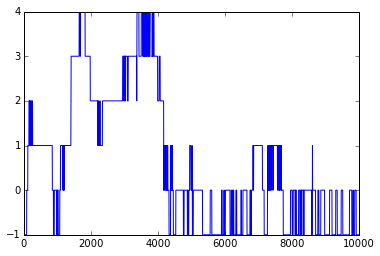

In [6]:
plt.plot(trace_readable)

In [7]:
repx_net = paths.ReplicaNetwork(storage=storage)

In [8]:
repx_net.flow(bottom=retis.minus_ensemble, top=retis.ensembles[-1])

{<openpathsampling.ensemble.MinusInterfaceEnsemble at 0x11a69c7d0>: 1.0,
 <openpathsampling.ensemble.TISEnsemble at 0x11a6615d0>: 0.0,
 <openpathsampling.ensemble.TISEnsemble at 0x11a661b50>: 0.7610439727835889,
 <openpathsampling.ensemble.TISEnsemble at 0x11a666e90>: 0.29822845342897514,
 <openpathsampling.ensemble.TISEnsemble at 0x11a675bd0>: 0.6950640231309376,
 <openpathsampling.ensemble.TISEnsemble at 0x11a675f50>: 0.9789114279975899,
 <openpathsampling.ensemble.TISEnsemble at 0x11a69c6d0>: 0.0890729145627146}

In [9]:
# TODO: there seems to be a bug here
repx_net.trips(bottom=retis.minus_ensemble, top=retis.ensembles[-1])

{'down': [2028], 'round': [8730], 'up': [6921, 6702, 4127]}

In [10]:
(n_try, n_acc) = repx_net.analyze_exchanges(storage)

In [21]:
n_try

{(<openpathsampling.ensemble.TISEnsemble at 0x11a6615d0>,
  <openpathsampling.ensemble.TISEnsemble at 0x11a69c6d0>): 448,
 (<openpathsampling.ensemble.TISEnsemble at 0x11a661b50>,
  <openpathsampling.ensemble.TISEnsemble at 0x11a675f50>): 487,
 (<openpathsampling.ensemble.TISEnsemble at 0x11a666e90>,
  <openpathsampling.ensemble.TISEnsemble at 0x11a675bd0>): 454,
 (<openpathsampling.ensemble.TISEnsemble at 0x11a675bd0>,
  <openpathsampling.ensemble.TISEnsemble at 0x11a661b50>): 495,
 (<openpathsampling.ensemble.TISEnsemble at 0x11a675f50>,
  <openpathsampling.ensemble.MinusInterfaceEnsemble at 0x11a69c7d0>): 149,
 (<openpathsampling.ensemble.TISEnsemble at 0x11a69c6d0>,
  <openpathsampling.ensemble.TISEnsemble at 0x11a666e90>): 498}

In [12]:
n_acc

{(<openpathsampling.ensemble.TISEnsemble at 0x11a6615d0>,
  <openpathsampling.ensemble.TISEnsemble at 0x11a69c6d0>): 246,
 (<openpathsampling.ensemble.TISEnsemble at 0x11a661b50>,
  <openpathsampling.ensemble.TISEnsemble at 0x11a675f50>): 142,
 (<openpathsampling.ensemble.TISEnsemble at 0x11a666e90>,
  <openpathsampling.ensemble.TISEnsemble at 0x11a675bd0>): 85,
 (<openpathsampling.ensemble.TISEnsemble at 0x11a675bd0>,
  <openpathsampling.ensemble.TISEnsemble at 0x11a661b50>): 115,
 (<openpathsampling.ensemble.TISEnsemble at 0x11a675f50>,
  <openpathsampling.ensemble.MinusInterfaceEnsemble at 0x11a69c7d0>): 149,
 (<openpathsampling.ensemble.TISEnsemble at 0x11a69c6d0>,
  <openpathsampling.ensemble.TISEnsemble at 0x11a666e90>): 126}

In [77]:
# initial setup of order
index_order = None
# dictionaries to be used to translate between orderings (these are the defaults)
if index_order == None:
    ensemble_to_number = { ens : repx_net.all_ensembles.index(ens) for ens in repx_net.all_ensembles }
else:
    ensemble_to_number = { ens : index_order.index(ens) for ens in index_order }

number_to_ensemble = { ensemble_to_number[k] : k for k in ensemble_to_number.keys()}
n_ensembles = len(ensemble_to_number)


# building the matrix
import scipy.sparse
import scipy.sparse.csgraph
import numpy as np
# TODO: replace with coo_matrix?
data = [float(n_acc[k]) / n_try[k] for k in n_try.keys()]
ens_i, ens_j = zip(*n_try.keys())
i = [ensemble_to_number[e] for e in ens_i]
j = [ensemble_to_number[e] for e in ens_j]
acc_matrix = scipy.sparse.coo_matrix((data, (i, j)), shape=(n_ensembles, n_ensembles))

# re-ordering according to RCM
labels = {k : sset0[number_to_ensemble[k]].replica for k in number_to_ensemble.keys()}
if index_order == None:
    # reorder based on RCM 
    rcm_perm = scipy.sparse.csgraph.reverse_cuthill_mckee(acc_matrix.tocsr())
    reverse_perm = { rcm_perm[k] : rcm_perm.tolist().index(rcm_perm[k]) for k in range(len(rcm_perm))}
    perm_i = [rcm_perm[ii] for ii in i]
    perm_j = [rcm_perm[jj] for jj in j]
    new_matrix = scipy.sparse.coo_matrix((data, (perm_i, perm_j)), shape=(n_ensembles, n_ensembles))
    reordered_labels = [labels[k] for k in rcm_perm]
else:
    reordered_labels = [labels[k] for k in labels.keys()]
    new_matrix = acc_matrix

reordered = pd.DataFrame(new_matrix.todense())
reordered.index = reordered_labels
reordered.columns = reordered_labels

reordered

,-1,0,1,2,3,4,5
-1,0,0.000000,0.000000,0.000000,0.000000,0.000000,0
0,1,0.000000,0.000000,0.000000,0.000000,0.000000,0
1,0,0.291581,0.000000,0.000000,0.000000,0.000000,0
2,0,0.000000,0.232323,0.000000,0.000000,0.000000,0
3,0,0.000000,0.000000,0.187225,0.000000,0.000000,0
4,0,0.000000,0.000000,0.000000,0.253012,0.000000,0
5,0,0.000000,0.000000,0.000000,0.000000,0.549107,0


,-1,0,1,2,3,4,5
-1,0,0.000000,0.000000,0.000000,0.000000,0.000000,0
0,1,0.000000,0.000000,0.000000,0.000000,0.000000,0
1,0,0.291581,0.000000,0.000000,0.000000,0.000000,0
2,0,0.000000,0.232323,0.000000,0.000000,0.000000,0
3,0,0.000000,0.000000,0.187225,0.000000,0.000000,0
4,0,0.000000,0.000000,0.000000,0.253012,0.000000,0
5,0,0.000000,0.000000,0.000000,0.000000,0.549107,0
